# Linear and Quadratic Discriminant Analysis (LDA & QDA)

In [1]:
import numpy as np
import pandas as pd
from math import pi,exp
from matplotlib import pyplot as plt
%matplotlib inline

### Explore Data

In [2]:
data = pd.read_csv('data/iris.csv',names=['sepal_length','sepal_width','petal_length','petal_width','iris_class'])
data.head()

,sepal_length,sepal_width,petal_length,petal_width,iris_class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# Clean iris column (strip away 'Iris-')
data['iris_class'] = data.apply(lambda row: row.iris_class.split('-')[1],axis=1)

In [4]:
data.iris_class.value_counts()

virginica     50
setosa        50
versicolor    50
Name: iris_class, dtype: int64

In [5]:
data[data.iris_class=='setosa'].describe()

,sepal_length,sepal_width,petal_length,petal_width
count,50.00000,50.000000,50.000000,50.00000
mean,5.00600,3.418000,1.464000,0.24400
std,0.35249,0.381024,0.173511,0.10721
min,4.30000,2.300000,1.000000,0.10000
25%,4.80000,3.125000,1.400000,0.20000
50%,5.00000,3.400000,1.500000,0.20000
75%,5.20000,3.675000,1.575000,0.30000
max,5.80000,4.400000,1.900000,0.60000


In [6]:
data.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


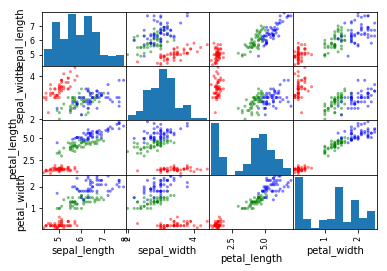

In [7]:
pd.plotting.scatter_matrix(data,c=data.iris_class.map({'setosa':'r','versicolor':'g','virginica':'b'}));

Based on these plots, it looks like 'petal_width' would do a decent job alone of classifying iris species. I say this because it appears that all the classes are more or less linearly seperable with respect to that attribute alone (looking at the far right column). I will investigate this further in Part 5.

### Useful Functions

In [8]:
np.array([[1,2],[3,4]]) @ np.array([[1,2],[3,4]])

array([[ 7, 10],
       [15, 22]])

In [9]:
# Gaussian probability density function for later
def gaussian_prob(x, mu, sig):
    """Returns the probability of x (column vector) given parameters mu(sample mean) and sig(covariance matrix)"""
    p = x.shape[0]    # number of dimensions
    coef = ((1/((2*pi)**p)*np.linalg.det(sig))**(1/2))
    return  (coef * exp(-0.5*(x-mu).T @ np.linalg.inv(sig) @ (x-mu)))

In [10]:
# Maximum Likelihood Estimation for the Covariance Matrix
def calc_covMatrix(data):
    """Returns the covariance of the matrix 'data'"""
    mu = np.array(data.mean(),ndmin=2).T
    sig = np.zeros((mu.shape[0],mu.shape[0]))
    for row in data.iterrows():
        x = np.array(row[1],ndmin=2).T
        sig += (x-mu) @ (x-mu).T
    return sig/(len(data)-1)

In [11]:
# Function to return accuracy of models
def model_accuracy(test_data,model):
    data_copy = test_data.copy()
    data_copy['prediction'] = data_copy.apply(lambda row: model(np.array(row,ndmin=2).T), axis=1)
    data_copy['iris_class'] = data.iris_class
    data_copy['pred_correct'] = data_copy.apply(lambda row: row.prediction == row.iris_class,axis=1)
    return len(data_copy[data_copy.pred_correct])/len(data_copy)

### 1.) Break sample into train/test datasets

In [12]:
# Split data into training/test data
setosa_train = data[data.iris_class=='setosa'].drop(['iris_class'],axis=1).iloc[0:40]
setosa_test = data[data.iris_class=='setosa'].drop(['iris_class'],axis=1).iloc[40:50]
versicolor_train = data[data.iris_class=='versicolor'].drop(['iris_class'],axis=1).iloc[0:40]
versicolor_test = data[data.iris_class=='versicolor'].drop(['iris_class'],axis=1).iloc[40:50]
virginica_train = data[data.iris_class=='virginica'].drop(['iris_class'],axis=1).iloc[0:40]
virginica_test = data[data.iris_class=='virginica'].drop(['iris_class'],axis=1).iloc[40:50]

all_train = pd.concat([setosa_train,versicolor_train,virginica_train])
all_test = pd.concat([setosa_test,versicolor_test,virginica_test])
all_ = pd.concat([all_train,all_test])

### 2.) LDA Classifier
- A Linear Discriminant Analysis (LDA) classifier will assume that: sigma_setosa = sigma_versicolor = sigma_virginica = sigma

In [13]:
# Estimate parameters based on Maximum Liklihood Estimation (MLE)
setosa_mu = np.array(setosa_train.mean(),ndmin=2).T
versicolor_mu = np.array(versicolor_train.mean(),ndmin=2).T
virginica_mu = np.array(virginica_train.mean(),ndmin=2).T

setosa_sig = calc_covMatrix(setosa_train)
versicolor_sig = calc_covMatrix(versicolor_train)
virginica_sig = calc_covMatrix(virginica_train)
combined_sig = (1/3)*(setosa_sig+versicolor_sig+virginica_sig)

In [14]:
def LDA_Classifier(x):
    probabilities = {
        'setosa': gaussian_prob(x,mu=setosa_mu,sig=combined_sig),
        'versicolor': gaussian_prob(x,mu=versicolor_mu,sig=combined_sig),
        'virginica': gaussian_prob(x,mu=virginica_mu,sig=combined_sig)
    }
    return max(probabilities, key=probabilities.get)

#### Results

In [15]:
print('Training data accuracy: ', model_accuracy(all_train,LDA_Classifier))
print('Test data accuracy: ', model_accuracy(all_test,LDA_Classifier))
print('All data accuracy: ', model_accuracy(all_,LDA_Classifier))

Training data accuracy:  0.975
Test data accuracy:  1.0
All data accuracy:  0.98


### 3.) QDA Classifier

In [16]:
def QDA_Classifier(x):
    probabilities = {
        'setosa': gaussian_prob(x,mu=setosa_mu,sig=setosa_sig),
        'versicolor': gaussian_prob(x,mu=versicolor_mu,sig=versicolor_sig),
        'virginica': gaussian_prob(x,mu=virginica_mu,sig=virginica_sig)
    }
    return max(probabilities, key=probabilities.get)

#### Results

In [17]:
print('Training data accuracy: ', model_accuracy(all_train,QDA_Classifier))
print('Test data accuracy: ', model_accuracy(all_test,QDA_Classifier))
print('All data accuracy: ', model_accuracy(all_,QDA_Classifier))

Training data accuracy:  0.975
Test data accuracy:  1.0
All data accuracy:  0.98


### 4.) Are Classes Linearly Seperable?

In [18]:
print('Setosa accuracy:',model_accuracy(pd.concat([setosa_test,setosa_train]),LDA_Classifier))
print('Versicolor accuracy:',model_accuracy(pd.concat([versicolor_test,versicolor_train]),LDA_Classifier))
print('Virginica accuracy:',model_accuracy(pd.concat([virginica_test,virginica_train]),LDA_Classifier))

Setosa accuracy: 1.0
Versicolor accuracy: 0.96
Virginica accuracy: 0.98


A class is linearly seperable all instances of it can be correctly predicted by a LDA classifier. By running all the data through my LDA classifier, we can see that the model correctly classifies all instances of the Setosa class. Thus, the Setosa class is linearly seperable from the other two species. 

This matches what I would expect based on the scatter matrix in the 'Expore Data' section. A quick glance at this scatter matrix shows that there is distinct seperation between Setosa and the other classes for most attributes.

### 5.) Importance of Features

Based on my experiments, both LDA and QDA classifiers are quite successful when trained only with the 'petal_width' attribute alone. While the other three attributes do provide a miniscule increase in accuracy, it may not be worth the increased complexity of the model. 

_This reduced model yielding the follwing results:_<br>
__LDA__<br>
Training data accuracy:  0.95<br>
Test data accuracy:  1.0<br>
All data accuracy:  0.96<br>

__QDA__<br>
Training data accuracy:  0.95<br>
Test data accuracy:  0.9666666666666667<br>
All data accuracy:  0.9533333333333334

As shown by the results, these reduced models are not far off from the accuracy of the LDA and QDA classifiers trained on all of the data. Thus I would say that __'sepal_length'__, __'sepal_width'__, and __'petal_length'__ are not important in classifying iris type.

### 6.) Models with Independent Features

In [19]:
def calc_covMatrix_ind(data):
    sig = calc_covMatrix(data)
    return sig * np.eye(len(sig))

In [20]:
setosa_sigInd = calc_covMatrix_ind(setosa_train)
versicolor_sigInd = calc_covMatrix_ind(versicolor_train)
virginica_sigInd = calc_covMatrix_ind(virginica_train)
combined_sigInd = (1/3)*(setosa_sigInd+versicolor_sigInd+virginica_sigInd)

#### LDA

In [21]:
def LDA_Classifier_ind(x):
    probabilities = {
        'setosa': gaussian_prob(x,mu=setosa_mu,sig=combined_sigInd),
        'versicolor': gaussian_prob(x,mu=versicolor_mu,sig=combined_sigInd),
        'virginica': gaussian_prob(x,mu=virginica_mu,sig=combined_sigInd)
    }
    return max(probabilities, key=probabilities.get)

In [22]:
print('Training data accuracy: ', model_accuracy(all_train,LDA_Classifier_ind))
print('Test data accuracy: ', model_accuracy(all_test,LDA_Classifier_ind))
print('All data accuracy: ', model_accuracy(all_,LDA_Classifier_ind))

Training data accuracy:  0.95
Test data accuracy:  1.0
All data accuracy:  0.96


#### QDA

In [23]:
def QDA_Classifier_ind(x):
    probabilities = {
        'setosa': gaussian_prob(x,mu=setosa_mu,sig=setosa_sigInd),
        'versicolor': gaussian_prob(x,mu=versicolor_mu,sig=versicolor_sigInd),
        'virginica': gaussian_prob(x,mu=virginica_mu,sig=virginica_sigInd)
    }
    return max(probabilities, key=probabilities.get)

In [24]:
print('Training data accuracy: ', model_accuracy(all_train,QDA_Classifier_ind))
print('Test data accuracy: ', model_accuracy(all_test,QDA_Classifier_ind))
print('All data accuracy: ', model_accuracy(all_,QDA_Classifier_ind))

Training data accuracy:  0.9416666666666667
Test data accuracy:  1.0
All data accuracy:  0.9533333333333334
